In [1]:
# start imagic code, our approach for v0
import requests
from PIL import Image
from io import BytesIO
import torch
import os
from diffusers import DiffusionPipeline, DDIMScheduler
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
        safety_checker=None,
    use_auth_token=True,
    custom_pipeline="imagic_stable_diffusion",
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
).to(device)
generator = torch.Generator("cuda").manual_seed(0)
seed = 0
prompt = "A photo of Barack Obama smiling with a big grin"
url = 'https://www.dropbox.com/s/6tlwzr73jd1r9yk/obama.png?dl=1'
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((512, 512))

/home/boyili/programfiles/anaconda3/envs/StableVideos/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 16 files: 100%|████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9764.13it/s]
/home/boyili/programfiles/anaconda3/envs/StableVideos/lib/python3.9/site-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
Downloading: 24.9kB [00:00, 16.0MB/s]                                                                                                 


In [2]:
res = pipe.train(
        prompt,
        image=init_image,
        generator=generator)

Keyword arguments {'truncaton': True} not recognized.
Steps: 100%|████████████████████████████████████████████████████████████████████████████| 500/500 [01:13<00:00,  6.76it/s, loss=0.178]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.89it/s, loss=0.00662]


In [3]:
res = pipe(alpha=1, guidance_scale=7.5, num_inference_steps=50)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.09it/s]


In [4]:
os.makedirs("imagic", exist_ok=True)
image = res.images[0]
image.save('./imagic/imagic_image_alpha_1.png')
res = pipe(alpha=1.5, guidance_scale=7.5, num_inference_steps=50)
image = res.images[0]
image.save('./imagic/imagic_image_alpha_1_5.png')
res = pipe(alpha=2, guidance_scale=7.5, num_inference_steps=50)
image = res.images[0]
image.save('./imagic/imagic_image_alpha_2.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.13it/s]


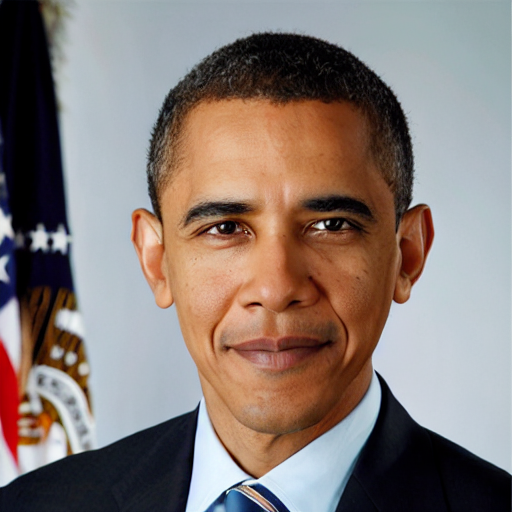

In [9]:
path = './imagic/imagic_image_alpha_1.png'
from IPython.display import Image
Image(filename=path) 

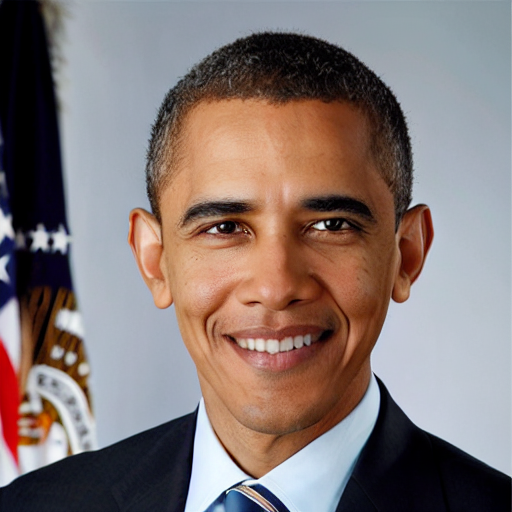

In [10]:
path = './imagic/imagic_image_alpha_1_5.png'
from IPython.display import Image
Image(filename=path) 

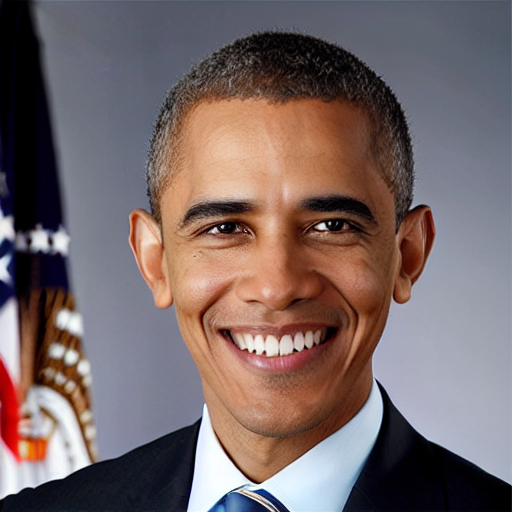

In [11]:
path = './imagic/imagic_image_alpha_2.png'
from IPython.display import Image
Image(filename=path) 